Other notes: 
* python -m ipykernel install --user --name py38 --display-name "Python (py38)" to be able to use the python environment when running the notebook

In [1]:
import requests
import numpy as np
import pandas as pd
from itertools import compress
from datetime import datetime
from datetime import timedelta  
import matplotlib
import matplotlib.pylab as plt
from matplotlib import cm
import matplotlib.dates as mdates
#import cartopy.feature as cft
import cartopy.crs as ccrs
from svgpath2mpl import parse_path
%matplotlib inline

**Functions are defined in the following. NOTE: we should check we only include functions that are used later!**

In [2]:
# get a tropical cyclone by date and year
def get_TCs_byNameYear(tc_name,tc_year):
    url = 'https://argovis.colorado.edu/tc/findByNameYear?name='+tc_name+'&year='+str(tc_year) #2018-07-15
    print(url)
    resp = requests.get(url)
    # Consider any status other than 2xx an error
    if not resp.status_code // 100 == 2:
        return "Error: Unexpected response {}".format(resp)
    data = resp.json()
    return data

In [3]:
# get tropical cyclones (or SH storms) by date
def get_TCs_byDate(startDate,endDate):
    url = 'https://argovis.colorado.edu/tc/findByDateRange?startDate='+startDate+'T00:00:00&endDate='+endDate+'T00:00:00' #2018-07-15
    print(url)
    resp = requests.get(url)
    # Consider any status other than 2xx an error
    if not resp.status_code // 100 == 2:
        return "Error: Unexpected response {}".format(resp)
    data = resp.json()
    return data

In [4]:
# create a marker for tropical cyclones
def get_hurricane_marker():
    hurricane = parse_path("""M 188.79857,492.55018 L 180.09663,484.17671 L 188.57725,474.97463 
     C 212.44187,449.07984 230.37031,423.34927 246.04359,392.5 
     C 254.14781,376.5487 265.0005,350.78866 265.0005,347.50373 
     C 265.0005,346.53236 263.21255,347.40666 259.7505,350.07094 
     C 251.67361,356.28665 233.85001,364.64767 222.5005,367.54485 
     C 204.24051,372.20605 178.92084,371.97166 159.45635,366.96123 
     C 147.77122,363.95331 130.93184,355.3283 122.0005,347.77659 
     C 95.11018,325.04006 81.65749,291.36529 81.74139,247 
     C 81.78993,221.33674 85.91479,197.1747 94.55247,171.95714 
     C 111.06665,123.74428 136.98179,82.210848 180.29075,34.54693 
     L 185.6999,28.59386 L 189.6002,31.718323 
     C 191.74536,33.436777 195.9159,37.308373 198.86805,40.32187 
     L 204.23561,45.800955 L 193.66355,57.483549 
     C 168.69038,85.080007 151.53704,109.91644 136.8182,139.79028 
     C 130.67851,152.2516 118.91503,180.17836 119.52809,180.83739 
     C 119.70071,181.02295 122.91512,178.62979 126.67122,175.51926 
     C 144.84799,160.46658 171.06913,152.9127 200.0005,154.39429 
     C 227.96505,155.82638 249.78837,164.40176 267.15103,180.78081 
     C 291.49094,203.74185 302.41509,234.21538 302.36063,279 
     C 302.33536,299.77768 300.97355,312.12979 296.41891,332.89349 
     C 286.70405,377.18157 262.85893,424.36347 228.55502,467.17452 
     C 219.26505,478.76833 199.25099,501.02345 198.17004,500.96183 
     C 197.80179,500.94084 193.58463,497.15559 188.79857,492.55018 
     z M 212.92994,343.99452 C 242.28307,336.85605 266.31414,312.68729 
     273.9846,282.59004 C 276.76052,271.6979 276.75301,253.72727 273.96762,242 
     C 266.78666,211.76606 241.98871,187.12253 211.5005,179.92186 
     C 203.8953,178.12567 200.40831,177.86988 189.0005,178.27134 
     C 173.93019,178.80168 167.30498,180.26871 156.08925,185.55888 
     C 132.8924,196.50023 116.23621,216.81521 109.90648,241.88639 
     C 108.09535,249.06004 107.84969,252.38603 108.2077,264.88639 
     C 108.58615,278.10034 108.93262,280.39476 111.82513,288.842 
     C 113.58452,293.98009 116.23139,300.28009 117.70707,302.842 
     C 137.50495,337.21285 174.70639,353.29022 212.92994,343.99452 z""")
    return hurricane
hurricane = get_hurricane_marker()
hurricane.vertices -= hurricane.vertices.mean()

In [5]:
# get profiles in any shape of interest
def get_selection_profiles(startDate, endDate, shape, presRange=None, printUrl=True):
    url = 'https://argovis.colorado.edu/selection/profiles'
    url += '?startDate={}'.format(startDate)
    url += '&endDate={}'.format(endDate)
    url += '&shape={}'.format(shape)
    if presRange:
        pressRangeQuery = '&presRange=' + presRange
        url += pressRangeQuery
    if printUrl:
        print(url)
    resp = requests.get(url)
    # Consider any status other than 2xx an error
    if not resp.status_code // 100 == 2:
        return "Error: Unexpected response {}".format(resp)
    selectionProfiles = resp.json()    
    return selectionProfiles

In [6]:
# parse profiles into a dataframe
def parse_into_df(profiles):
    meas_keys = profiles[0]['measurements'][0].keys()
    df = pd.DataFrame(columns=meas_keys)
    for profile in profiles:
        profileDf = pd.DataFrame(profile['measurements'])
        profileDf['cycle_number'] = profile['cycle_number']
        profileDf['profile_id'] = profile['_id']
        profileDf['lat'] = profile['lat']
        profileDf['lon'] = profile['lon']
        profileDf['date'] = profile['date']
        df = pd.concat([df, profileDf], sort=False)
    return df

In [7]:
def plot_tracks_time_in_col(TCs_Dict):
    for i in range(0,len(TCs_Dict)):
        df  = pd.DataFrame(TCs_Dict[i]['traj_data'])
        dti = pd.to_datetime(df['timestamp'])
        #plt.plot(df['lon'],df['lat'],transform=ccrs.Geodetic(),c='k')
        plt.scatter(df['lon'],df['lat'],transform=ccrs.Geodetic(),s=5,c=mdates.date2num(dti))
    # cb = plt.colorbar()
    # loc = mdates.AutoDateLocator()
    # cb.ax.yaxis.set_major_locator(loc)
    # cb.ax.yaxis.set_major_formatter(mdates.ConciseDateFormatter(loc))
    plt.show()

In [8]:
def TC_and_stroms_view(startDate,endDate,tag_TC_or_SH_FILT='TC'):
    TCs_Dict = get_TCs_byDate(startDate,endDate=endDate)
    fig = plt.figure(figsize=(15,15))

    ax = plt.axes(projection=ccrs.Mollweide())
    ax.stock_img()

    bool_list = [] #True*len(TCs_Dict)
    for x in TCs_Dict:
        if ('SH_FILT' in tag_TC_or_SH_FILT):
            bool_list.append('SH_FILT' in x['_id'])
        else:
            bool_list.append(~('SH_FILT' in x['_id']))
            
    output_select = list(compress(TCs_Dict, bool_list))
    
    plot_tracks_time_in_col(list(compress(TCs_Dict, bool_list)))
    return output_select

In [9]:
def plot_prof(dataX,dataY,xlab,ylab,xlim,ylim,col):

    plt.plot(dataX,dataY,color=col,linewidth=5)

#     #ax.set_title('An Argo Profile \n in the style of XKCD')
    plt.gca().set_xlabel(xlab,fontsize=24)
    plt.gca().set_ylabel(ylab,fontsize=24)
    plt.ylim(ylim)
    if xlim:
        plt.xlim(xlim)
    plt.gca().invert_yaxis()
    #ax.invert_yaxis()
    
    for tick in plt.gca().xaxis.get_majorticklabels():  # example for xaxis
        tick.set_fontsize(24) 
    for tick in plt.gca().yaxis.get_majorticklabels():  # example for xaxis
        tick.set_fontsize(24) 
    return

**Let's now get and plot all the TC/SH storms in a time window of interest. Tracks will show up if one of their points occurs in the time window of interest. Too large time windows will not work as there is a limit to the size of the request. If a long time window is needed, the request could be made e.g. month by month, using in a loop.**

Let's first look at the southern hemisphere.

https://argovis.colorado.edu/tc/findByDateRange?startDate=2017-12-20T00:00:00&endDate=2018-02-15T00:00:00


ValueError: Invalid transform: Spherical scatter is not supported - consider using PlateCarree/RotatedPole.

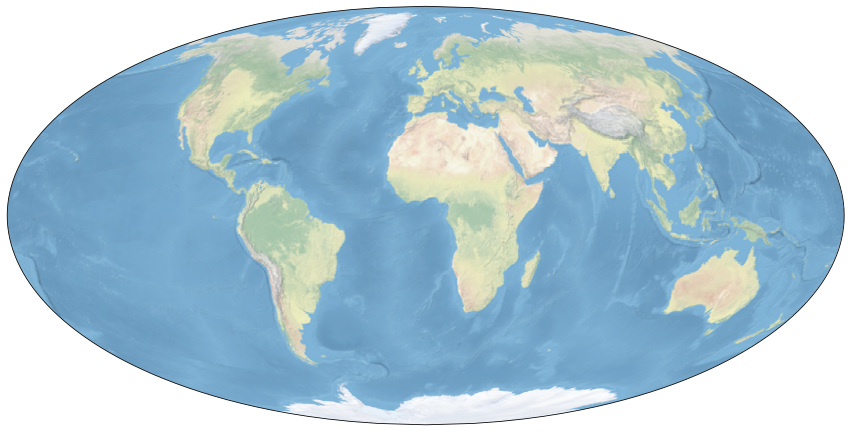

In [10]:
SH_storms = TC_and_stroms_view(startDate='2017-12-20',endDate='2018-02-15',tag_TC_or_SH_FILT='SH_FILT') #startDate='2018-07-15',endDate='2018-09-15')

Let's now look at the tropics.

In [ ]:
TCs = TC_and_stroms_view(startDate='2017-07-01',endDate='2017-09-30') #startDate='2018-07-15',endDate='2018-09-15')

**Let's look at the list of names (for those TC that have names)**

In [ ]:
for x in TCs:
    # print(x['_id'])
    if 'name' in x.keys():
        print('ID: ' + x['_id']+'; '+x['name']+' '+str(x['year']))    

**Now let's pick a name and year and query Argo profiles near a TC of interest**

In [ ]:
# let's note the name and year of interest
tc_name = 'maria'#'isaac'#'matthew' #'madeline' #'lester'
tc_year = 2017
# let's load the track of interest
tc_star = get_TCs_byNameYear(tc_name,tc_year)#'humberto',2019)
df  = pd.DataFrame(tc_star[0]['traj_data'])

# let's set the param for the co-location with Argo profile (for now we use a box around the point based on lon and lat, it can be improved)
delta_days = 7
dx = .75
dy = .75
presRange=[0,100]
  
# xmin = -95 #-178
# xmax = -50 #-110
# ymin = 10
# ymax = 40  

In [ ]:
prof_beforeTC = []
prof_afterTC  = []

fig = plt.figure(figsize=(15,15))

ax = plt.axes(projection=ccrs.PlateCarree()) #Mollweide
ax.coastlines()
#ax.add_feature(cft.LAND)
#ax.add_feature(cft.OCEAN)
#ax.add_feature(cft.COASTLINE)
#ax.add_feature(cft.BORDERS, linestyle=':')
#ax.set_extent([xmin,xmax, ymin, ymax],crs=ccrs.PlateCarree())

im = plt.scatter(df['lon'],df['lat'],transform=ccrs.Geodetic(),s=2000,marker=hurricane, 
            c=df['wind'], facecolors='none', linewidth=3.5)
# look for "before" profiles
dti = pd.to_datetime(df['timestamp'])
for i in np.arange(0,len(df['lon']),1):
    for ii in np.arange(0,2,1):
        if ii == 0:
            startDate=str(dti[i]-timedelta(days=delta_days))[0:10]
            endDate=str(dti[i])[0:10]
            mrkr = '*'
            col = 'k'
        else:
            startDate=str(dti[i])[0:10]
            endDate=str(dti[i]+timedelta(days=delta_days))[0:10]
            mrkr = '*' 
            col = 'red'
        shape = [[[df['lon'][i]-(dx/2),df['lat'][i]-(dy/2)],[df['lon'][i]-(dx/2),df['lat'][i]+(dy/2)],[df['lon'][i]+(dx/2),df['lat'][i]+(dy/2)],[df['lon'][i]+(dx/2),df['lat'][i]-(dx/2)],[df['lon'][i]-(dx/2),df['lat'][i]-(dy/2)]]]
        
        strShape = str(shape).replace(' ', '')
        selectionProfiles = get_selection_profiles(startDate, endDate, strShape, str(presRange), printUrl=False)
        selectionProfiles_raw = selectionProfiles
        if len(selectionProfiles) > 0 and not isinstance(selectionProfiles,str):
            selectionDf = parse_into_df(selectionProfiles)
            selectionDf.replace(-999, np.nan, inplace=True)

            gb     = selectionDf.groupby(by='profile_id')
            groups = dict(list(gb))
            gb_list = gb.groups.keys()
            
            if ii == 0:
                prof_beforeTC.append(groups)
            else:
                prof_afterTC.append(groups)
            for tag_id in gb_list:
#                 print('----------------------------')
#                 print(col)
#                 print(tag_id)
#                 print(groups[tag_id]['date'][0])
#                 print('tc (time, lon, lat):')
#                 print(dti[i])
#                 print(df['lon'][i])
#                 print(df['lat'][i])
               
                plt.plot(groups[tag_id]['lon'][0],groups[tag_id]['lat'][0],mrkr,transform=ccrs.Geodetic(),markersize=15,linewidth=4,color=col)
                
#                 if groups[list(gb_list)[j]]['lon'][0]>=xmin and groups[list(gb_list)[j]]['lon'][0]<=xmax and \
#                 groups[list(gb_list)[j]]['lat'][0]>=ymin and groups[list(gb_list)[j]]['lat'][0]<=ymax:
                if col=='k':
                    ax.text(groups[tag_id]['lon'][0]+.25, groups[tag_id]['lat'][0], tag_id,transform=ccrs.Geodetic(),color=col)
                elif col=='red':
                    ax.text(groups[tag_id]['lon'][0]+.25, groups[tag_id]['lat'][0], tag_id,transform=ccrs.Geodetic(),color=col)
        else:
            if ii == 0:
                prof_beforeTC.append([])
            else:
                prof_afterTC.append([])
plt.show()

**For some locations on the track, we may have profiles before and after: let's look at profiles near these locations, if any**

In [ ]:
for x,y in zip(prof_beforeTC,prof_afterTC):
    if any(x) and any(y):
        print('-------------')
        # temperature
        fig = plt.figure(figsize=(20,10))
        plt.subplot(121)
        for d in x.keys():
            print('Temperature, before (black): ' + d)
            plot_prof(dataX=x[d]['temp'],dataY=x[d]['pres'],xlab='Temperature, degC',ylab='Pressure, dbar',xlim=[],ylim=presRange,col='k')
        for d in y.keys():
            print('Temperature, after (red): ' + d)
            plot_prof(dataX=y[d]['temp'],dataY=y[d]['pres'],xlab='Temperature, degC',ylab='Pressure, dbar',xlim=[],ylim=presRange,col='r')
        # salinity
        plt.subplot(122)
        for d in x.keys():
            print('Salinity, before (black): ' + d)
            try:
                plot_prof(dataX=x[d]['psal'],dataY=x[d]['pres'],xlab='Salinity, psu',ylab='Pressure, dbar',xlim=[],ylim=presRange,col='k')
            except:
                pass
        for d in y.keys():
            print('Salinity, after (red): ' + d)
            try:
                plot_prof(dataX=y[d]['psal'],dataY=y[d]['pres'],xlab='Salinity, psu',ylab='Pressure, dbar',xlim=[],ylim=presRange,col='r')
            except:
                pass
        

## Let's now make a plot for SOSE sea ice ##

In [ ]:
# we define lists for the input to the function that gets SOSE sea icea data
yreg_ALL = np.arange(-90.,-10.,40.).tolist()
xreg_ALL = np.arange(-60.,-45.,5.).tolist() #(-180.,180.,5.)
date_ALL = ['2013-06-01']

In [ ]:
def get_SOSE_sea_ice(xreg,yreg,date,printUrl=True):
    # yreg, xreg, date should be lists
    url  = 'https://argovis.colorado.edu/griddedProducts/nonUniformGrid/window?'
    url += 'gridName=sose_si_area_1_day_sparse&presLevel=0&'
    url += 'latRange={}'.format(yreg)
    url += '&lonRange={}'.format(xreg)
    url += '&date={}'.format(date)
    if printUrl:
        print(url)
    resp = requests.get(url)
    # Consider any status other than 2xx an error
    if not resp.status_code // 100 == 2:
        return "Error: Unexpected response {}".format(resp)
    selectionSeaIce = resp.json()    
    return selectionSeaIce
    

In [ ]:
# parse profiles into a dataframe
def parse_into_df_SeaIce(selectionSeaIce):
    meas_keys = selectionSeaIce[0]['data'][0].keys()
    df = pd.DataFrame(columns=meas_keys)
    for data in selectionSeaIce[0]['data']:
        bfrDf = pd.DataFrame(data={'lon':  [data['lon']], 'lat':  [data['lat']], 'value':  [data['value']]}) #pd.DataFrame(data={'lon':  data['lon'], 'lat':  data['lat']})
        df = pd.concat([df, bfrDf], sort=False)
    return df

In [ ]:
color_map = plt.cm.get_cmap('Blues')
reversed_color_map = color_map.reversed()
for l in np.arange(0,len(date_ALL)):
    fig = plt.figure(figsize=(15,15))
    ax = plt.axes(projection=ccrs.SouthPolarStereo())
    ax.coastlines()
    #ax.add_feature(cft.LAND)
    #ax.add_feature(cft.OCEAN)
    #ax.stock_img()
    ax.set_extent([-180, 180, -90, -35], crs=ccrs.PlateCarree())

    for i in np.arange(0,len(xreg_ALL)-1):
        for j in np.arange(0,len(yreg_ALL)-1):
            selectionSeaIce  = get_SOSE_sea_ice(xreg=xreg_ALL[i:i+2],yreg=yreg_ALL[j:j+2],date=date_ALL[l])
            df_SeaIce       = parse_into_df_SeaIce(selectionSeaIce)
            plt.scatter(df_SeaIce['lon'],df_SeaIce['lat'],transform=ccrs.Geodetic(),s=5,cmap=reversed_color_map,c=df_SeaIce['value'])
        
    colorbar = plt.colorbar()

In [ ]:
# 7900370_18